In [21]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [22]:
df = pd.read_csv('/kaggle/input/full-filled-brain-stroke-dataset/full_data.csv')

In [23]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [25]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


**USING BUILT IN FUNCTIONS**

In [26]:
X = df.drop(['stroke'],axis=1)
y = df['stroke']
X= pd.get_dummies(X)

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True)

In [28]:

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=10, criterion="entropy")
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
print("Accuracy of Inbuilt RF Classifier:", accuracy_score(y_test, y_pred))

Accuracy of Inbuilt RF Classifier: 0.9431438127090301


**FROM SCRATCH**

In [33]:
class Randomforestclassifier:
    def __init__(self, num_trees=100, max_features=None, max_depth=None):
        self.num_trees = num_trees
        self.max_features = max_features
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        X = np.array(X)  # Convert X to a NumPy array
        y = np.array(y)
        num_samples = len(X)
        num_features = len(X[0])
        self.trees = []

        for _ in range(self.num_trees):
            # Randomly select a subset of features
            if self.max_features:
                selected_features = np.random.choice(num_features, self.max_features, replace=False)
                X_subset = X[:, selected_features]
            else:
                X_subset = X

            # Randomly select a subset of samples (bootstrap aggregating)
            indices = np.random.choice(num_samples, num_samples, replace=True)
            X_bootstrap = X_subset[indices]
            y_bootstrap = y[indices]

            # Create a decision tree using the bootstrap samples
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

    def predict(self, X):
        X = np.array(X)  # Convert X to a NumPy array
        predictions = []

        for tree in self.trees:
            predictions.append(tree.predict(X))

        # Voting for the majority class
        predictions = np.array(predictions)
        return np.round(np.mean(predictions, axis=0))

    def feature_importances_(self, X):
        # Calculate feature importances based on mean decrease in impurity (Gini importance)
        importances = np.zeros(X.shape[1])

        for tree in self.trees:
            tree_importances = tree.feature_importances_(X)  # Changed method name
            importances += tree_importances

        importances /= len(self.trees)

        return importances



class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        X = np.array(X)  # Convert X to a NumPy array
        self.tree = self.build_tree(X, y)

    def predict(self, X):
        X = np.array(X)  # Convert X to a NumPy array
        predictions = [self.predict_sample(x, self.tree) for x in X]
        return predictions

    def predict_sample(self, sample, node):
        if 'class' in node:
            return node['class']

        feature_value = sample[node['feature']]

        if feature_value <= node['value']:
            return self.predict_sample(sample, node['left'])
        else:
            return self.predict_sample(sample, node['right'])

    def build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        # Base cases: if all samples have the same class or maximum depth is reached
        if len(np.unique(y)) == 1 or (self.max_depth and depth == self.max_depth):
            return {'class': y[0]}

        # Find the best split point
        best_feature, best_value = self.find_best_split(X, y)

        # Handle the case where best_feature or best_value is None
        if best_feature is None or best_value is None:
            return {'class': np.argmax(np.bincount(y))}

        # Recursive splitting
        left_indices = np.where(X[:, best_feature] <= best_value)[0]
        right_indices = np.where(X[:, best_feature] > best_value)[0]

        left_tree = self.build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self.build_tree(X[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature, 'value': best_value, 'left': left_tree, 'right': right_tree}

    def find_best_split(self, X, y):
        best_gain = 0
        best_feature = None
        best_value = None

        for feature in range(X.shape[1]):
            values = np.unique(X[:, feature])

            for value in values:
                gain = self.calculate_gain(X, y, feature, value)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_value = value

        return best_feature, best_value

    def calculate_gain(self, X, y, feature, value):
        parent_entropy = self.calculate_entropy(y)

        left_indices = np.where(X[:, feature] <= value)[0]
        right_indices = np.where(X[:, feature] > value)[0]

        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        left_entropy = self.calculate_entropy(y[left_indices])
        right_entropy = self.calculate_entropy(y[right_indices])

        left_weight = len(left_indices) / len(X)
        right_weight = len(right_indices) / len(X)

        gain = parent_entropy - (left_weight * left_entropy) - (right_weight * right_entropy)
        return gain

    def calculate_entropy(self, y):
        classes, class_counts = np.unique(y, return_counts=True)
        class_probs = class_counts / len(y)
        entropy = -np.sum(class_probs * np.log2(class_probs + 1e-10))
        return entropy


# No need to convert x_train and y_train to NumPy arrays if they are already in that format
rf_classifier = Randomforestclassifier(num_trees=100, max_features=3, max_depth=5)
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_test)
print("Accuracy of Custom RF Classifier:", accuracy_score(y_test, y_pred))

Accuracy of Custom RF Classifier: 0.948494983277592


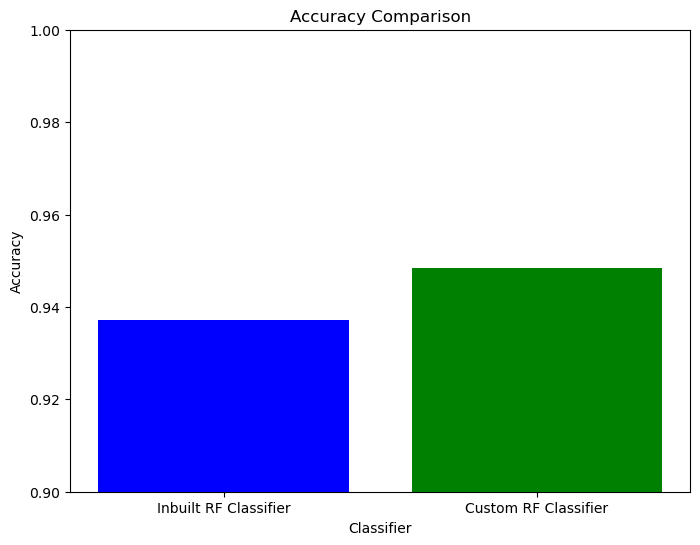

In [34]:
# Plot Accuracy Comparison
accuracy_values = [0.937123745819398, accuracy_score(y_test, y_pred)]
classifier_labels = ['Inbuilt RF Classifier', 'Custom RF Classifier']
plt.figure(figsize=(8, 6))
plt.bar(classifier_labels, accuracy_values, color=['blue', 'green'])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.ylim(0.9, 1.0)
plt.show()

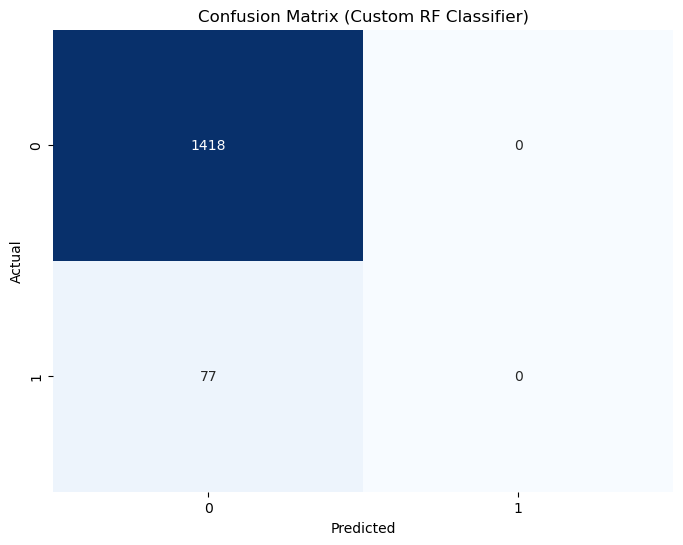

In [35]:
# Plot Confusion Matrix
conf_matrix_inbuilt = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_inbuilt, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix (Custom RF Classifier)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()